In [5]:

import gunpowder as gp
import h5py
import io
import logging
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import requests
import torch
import waterz
import zarr

from funlib.learn.torch.models import UNet, ConvPass
from gunpowder.torch import Predict
from scipy.ndimage import label, measurements
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import distance_transform_edt
from skimage.segmentation import watershed

logging.basicConfig(level=logging.INFO)

/tmp/ipykernel_1800/611294079.py:18: DeprecationWarning: Please use `maximum_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import maximum_filter
/tmp/ipykernel_1800/611294079.py:19: DeprecationWarning: Please use `distance_transform_edt` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import distance_transform_edt


This is the random index: 14
This is the shape of gt_affinities before: (3, 20, 128, 128)
This is the shape of gt_affinities after: (128, 128)
This is the shape of pred_affinities: (128, 128)
This is the random index: 14
This is the shape of gt_affinities before: (3, 20, 128, 128)
This is the shape of gt_affinities after: (128, 128)
This is the shape of pred_affinities: (128, 128)
This is the random index: 15
This is the shape of gt_affinities before: (3, 20, 128, 128)
This is the shape of gt_affinities after: (128, 128)
This is the shape of pred_affinities: (128, 128)
This is the random index: 14
This is the shape of gt_affinities before: (3, 20, 128, 128)
This is the shape of gt_affinities after: (128, 128)
This is the shape of pred_affinities: (128, 128)
This is the random index: 13
This is the shape of gt_affinities before: (3, 20, 128, 128)
This is the shape of gt_affinities after: (128, 128)
This is the shape of pred_affinities: (128, 128)
This is the random index: 0
This is the 

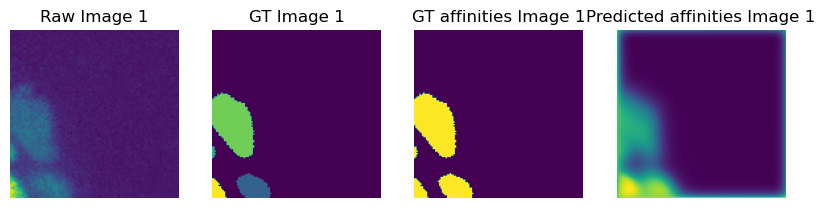

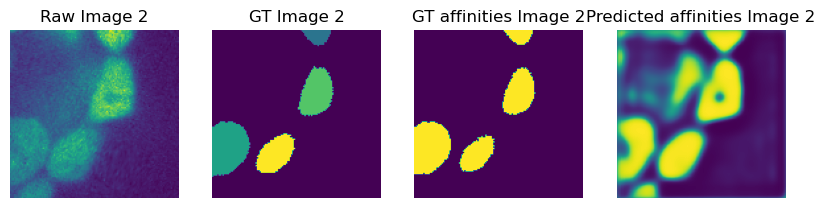

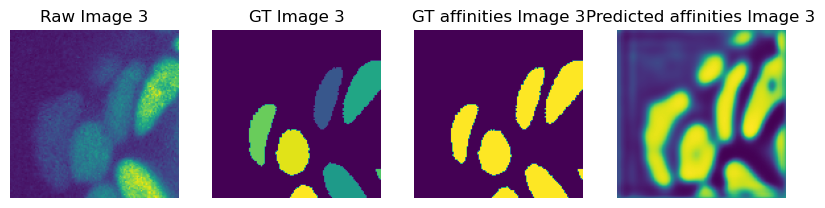

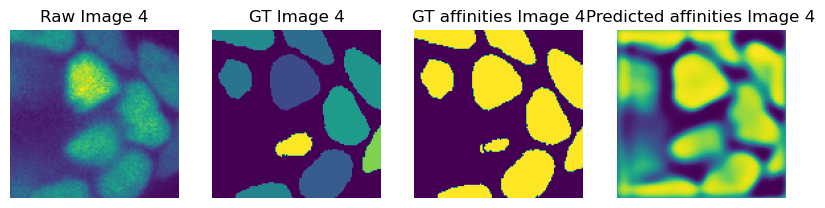

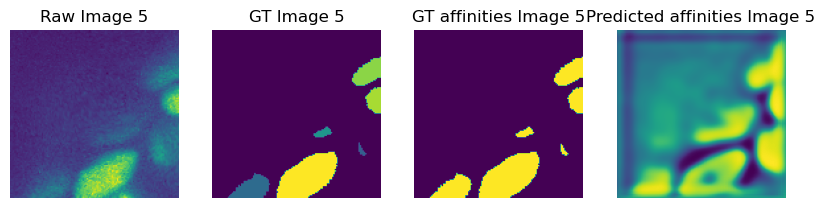

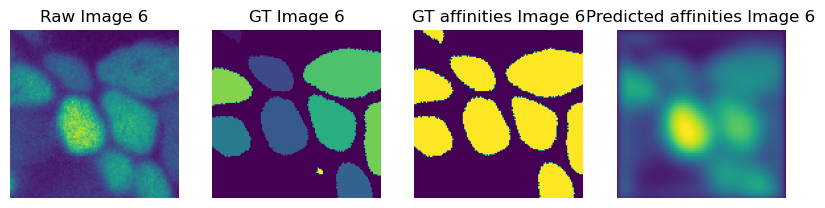

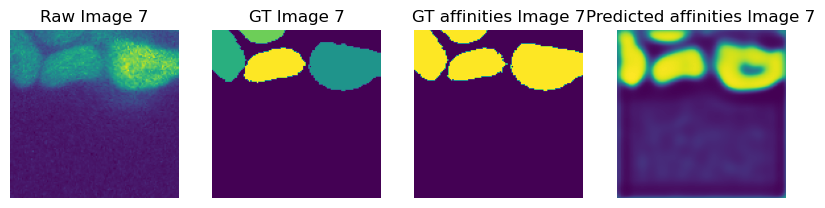

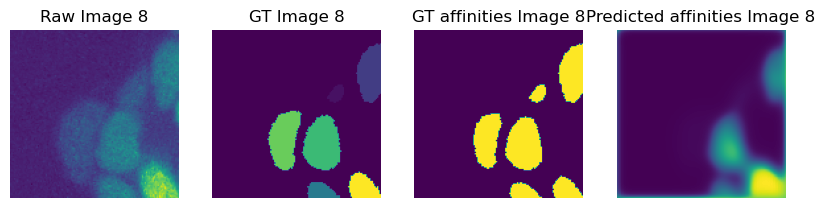

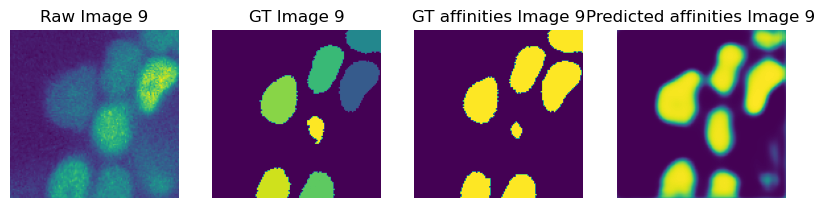

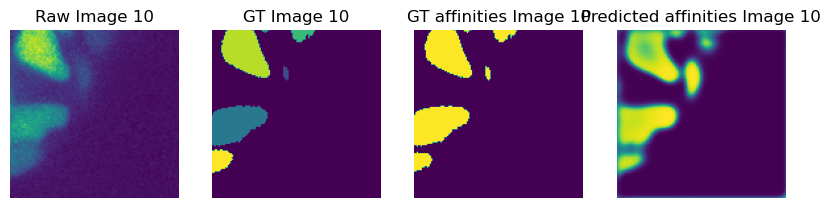

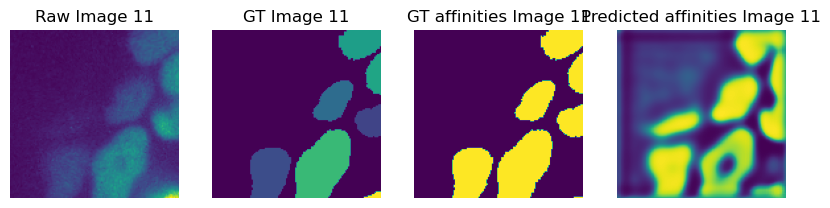

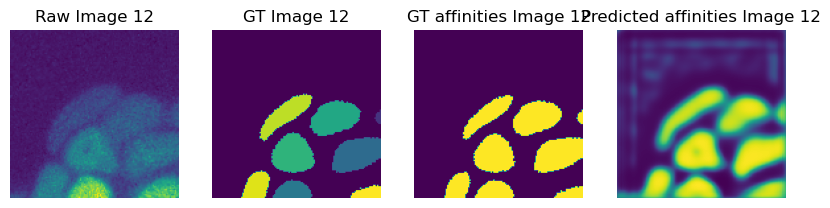

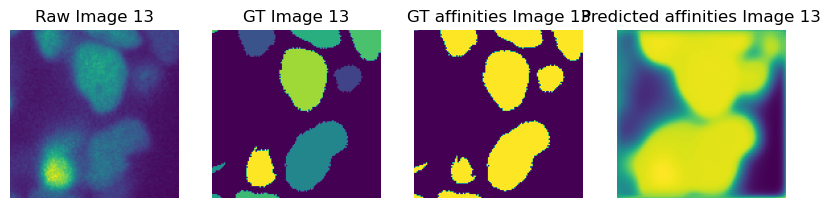

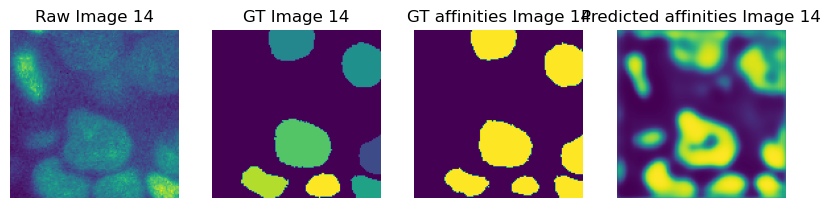

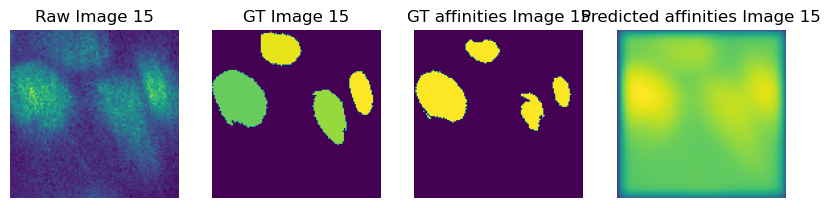

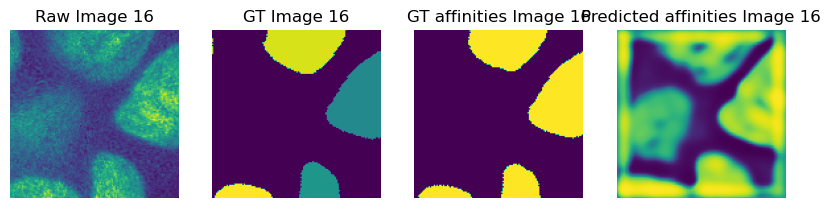

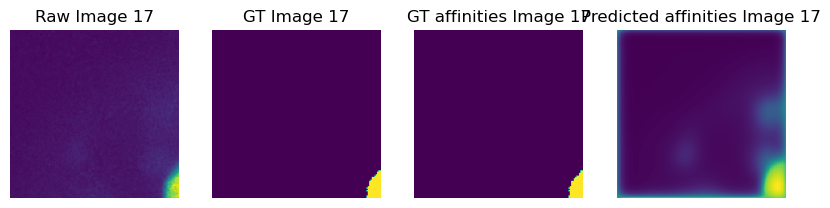

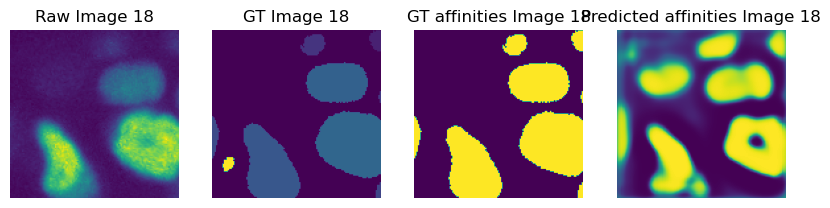

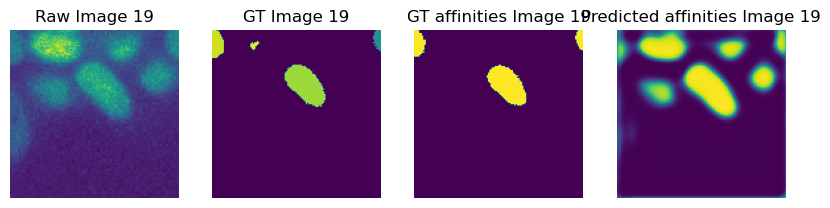

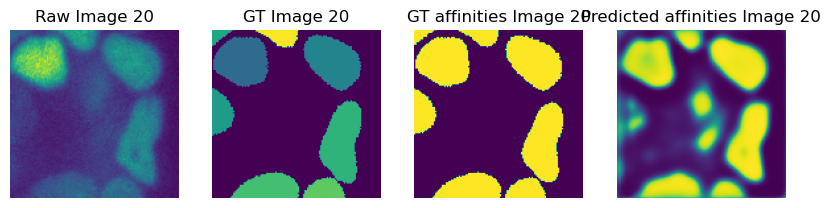

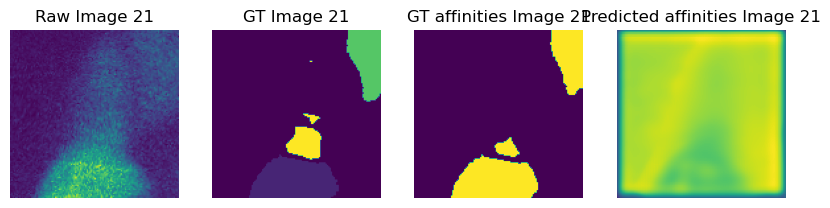

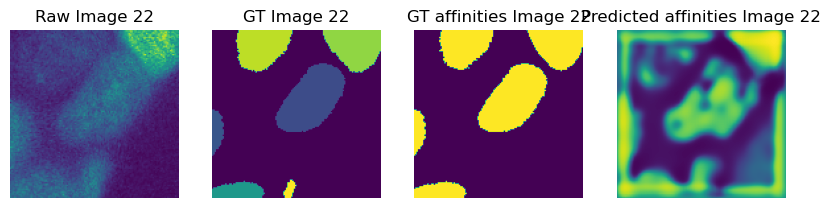

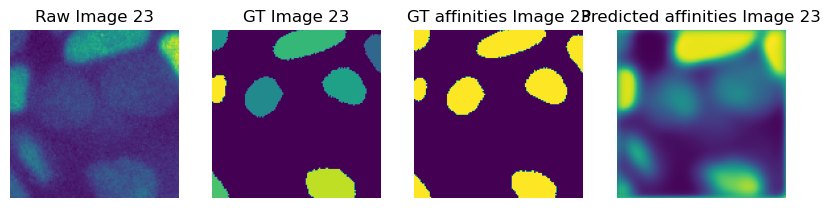

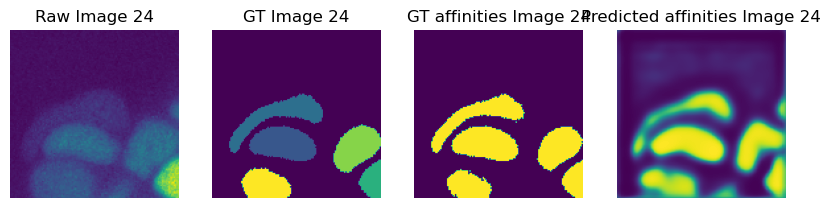

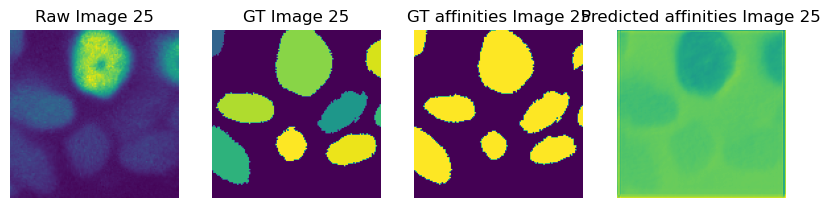

In [6]:
load_path = "/mnt/efs/shared_data/hack/lsd/mjs_onlyaffs_norm3000_exp5/snapshot"

# List all Zarr files in the folder
zarr_files = [file for file in os.listdir(load_path) if file.endswith('.zarr')]

# Create a dictionary to store 'raw' and 'gt' images
all_images = []

# Select the z-plane you want to view (replace with your desired z-plane)
z_plane_to_view = 12
affinity_to_view = 1

# Loop through each Zarr file
for zarr_file in zarr_files:
    # Open the Zarr file
    zarr_path = os.path.join(load_path, zarr_file)
    zarr_group = zarr.open(zarr_path, mode='r')
    # Check if the Zarr file contains 'raw' and 'gt' datasets
    if 'raw' in zarr_group and 'gt' in zarr_group and 'gt_affinities' in zarr_group and 'pred_affinities' in zarr_group:
        # Load a random example image from the 'raw' dataset
        random_index = random.randint(0, len(zarr_group['raw']) - 1)
        print(f'This is the random index: {random_index}')
        raw_image = zarr_group['raw'][random_index]
        raw_image = zarr_group['raw'][random_index][0, z_plane_to_view, :, :]

        # Load the corresponding 'gt' image
        gt_image = zarr_group['gt'][random_index][z_plane_to_view, :, :]

        #load the corresponding 'gt_affinities' image
        gt_affinities_image = zarr_group['gt_affinities'][random_index]
        print(f'This is the shape of gt_affinities before: {gt_affinities_image.shape}')
        gt_affinities_image = zarr_group['gt_affinities'][random_index][affinity_to_view, z_plane_to_view, :, :]
        print(f'This is the shape of gt_affinities after: {gt_affinities_image.shape}')

        # load the corresponding 'pred_affinities' image
        pred_affinities_image = zarr_group['pred_affinities'][random_index][affinity_to_view, z_plane_to_view, :, :]
        print(f'This is the shape of pred_affinities: {pred_affinities_image.shape}')
        # Append the 'raw' and 'gt' and 'gt_affinities' and 'pred_affinities' to the list
        all_images.append((raw_image, gt_image, gt_affinities_image, pred_affinities_image))



#%%

for i, (raw_image, gt_image, gt_affinities_image, pred_affinities_image) in enumerate(all_images):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 4, 1)
    plt.imshow(raw_image, cmap='viridis')
    plt.title(f'Raw Image {i+1}')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(gt_image, cmap='viridis')
    plt.title(f'GT Image {i+1}')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(gt_affinities_image, cmap='viridis')
    plt.title(f'GT affinities Image {i+1}')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(pred_affinities_image, cmap='viridis')
    plt.title(f'Predicted affinities Image {i+1}')
    plt.axis('off')

    plt.show()


In [7]:
def watershed_from_boundary_distance(
        boundary_distances,
        boundary_mask,
        id_offset=0,
        min_seed_distance=10):

    max_filtered = maximum_filter(boundary_distances, size=min_seed_distance)
    maxima = (max_filtered == boundary_distances)
    seeds, n = label(maxima)

    print(f"Found {n} fragments")

    if n == 0:
        return np.zeros_like(boundary_distances, dtype=np.uint64), id_offset

    seeds[seeds != 0] += id_offset

    fragments = watershed(
        boundary_distances.max() - boundary_distances,
        markers=seeds, #was seeds
        mask=boundary_mask)

    return fragments.astype(np.uint64), n + id_offset #ret 

In [8]:

#@title watershed wrappers
def watershed_from_boundary_distance(
        boundary_distances,
        boundary_mask,
        id_offset=0,
        min_seed_distance=10):

    max_filtered = maximum_filter(boundary_distances, min_seed_distance)
    maxima = max_filtered==boundary_distances
    seeds, n = label(maxima)

    print(f"Found {n} fragments")

    if n == 0:
        return np.zeros(boundary_distances.shape, dtype=np.uint64), id_offset

    seeds[seeds!=0] += id_offset

    fragments = watershed(
        boundary_distances.max() - boundary_distances,
        seeds,
        mask=boundary_mask)

    ret = (fragments.astype(np.uint64), n + id_offset)

    return ret

In [9]:
def watershed_from_affinities(
        affs,
        max_affinity_value=1.0,
        id_offset=0,
        min_seed_distance=10):

    mean_affs = 0.5 * (affs[0] + affs[1] + affs[2])
    boundary_mask = mean_affs > 0.5 * max_affinity_value
    boundary_distances = distance_transform_edt(boundary_mask)

    return watershed_from_boundary_distance(
        boundary_distances,
        boundary_mask,
        id_offset=id_offset,
        min_seed_distance=min_seed_distance)


def get_segmentation(affinities, threshold):
    fragments = watershed_from_affinities(affinities)[0]
    thresholds = [threshold]

    generator = waterz.agglomerate(
        affs=affinities.astype(np.float32),
        fragments=fragments,
        thresholds=thresholds,
    )

    return next(generator)

In [10]:
segmentations = []
affinities = 'pred_affinities'
# chosen_affinities = 'gt_affinities'
batchnumber = 1

for zarr_file in zarr_files:
    # Open the Zarr file
    zarr_path = os.path.join(load_path, zarr_file)
    zarr_snap = zarr.open(zarr_path, mode='r')

    print(f'This is the shape of zarr_snap: {zarr_snap[chosen_affinities].shape}')

    pred_affs = zarr_snap[chosen_affinities][batchnumber]
    ws_affs = np.stack([
    pred_affs[0],
    pred_affs[1],
    pred_affs[2]]
    )
    print(f'This is the shape of pred_affs: {pred_affs.shape}')

    print(f'This is the shape of ws_affs: {ws_affs.shape}')
    threshold = 0.5
    segmentation = get_segmentation(ws_affs, threshold)
    segmentations.append(segmentation)

    

NameError: name 'chosen_affinities' is not defined

In [11]:
segmentations = []
affinities = 'pred_affinities'
# chosen_affinities = 'gt_affinities'
batchnumber = 5

z_plane_to_view = 12
all_images = []


for zarr_file in zarr_files:
    # Open the Zarr file
    zarr_path = os.path.join(load_path, zarr_file)
    zarr_snap = zarr.open(zarr_path, mode='r')

    print(f'This is the shape of zarr_snap: {zarr_snap[chosen_affinities].shape}')

    pred_affs = zarr_snap[chosen_affinities][batchnumber]
    ws_affs = np.stack([
    pred_affs[0],
    pred_affs[1],
    pred_affs[2]]
    )
    print(f'This is the shape of pred_affs: {pred_affs.shape}')

    print(f'This is the shape of ws_affs: {ws_affs.shape}')
    threshold = 0.5
    segmentation = get_segmentation(ws_affs, threshold)
    segmentations.append(segmentation)

    # Extract the raw and gt images from the Zarr file
    if 'raw' in zarr_snap and 'gt' in zarr_snap:
            # Load a random example image from the 'raw' dataset
        random_index = random.randint(0, len(segmentations) - 1)
        print(f'This is the raw image shape: {zarr_snap["raw"][random_index].shape}')
        raw_image = zarr_snap['raw'][random_index][0, z_plane_to_view, :, :]
        gt_image = zarr_snap['gt'][random_index][z_plane_to_view, :, :]
        segmentations_image = segmentations[random_index][z_plane_to_view,:, :]

        all_images.append((raw_image, gt_image, segmentations_image))


for i, (raw_image, gt_image, segmentations_image) in enumerate(all_images):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(raw_image, cmap='viridis')
    plt.title(f'Raw Image {i+1}')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(gt_image, cmap='viridis')
    plt.title(f'GT Image {i+1}')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(segmentations_image, cmap='viridis')
    plt.title(f'Segmentations image {i+1}')
    plt.axis('off')


    plt.show()

NameError: name 'chosen_affinities' is not defined

In [12]:
len(segmentations)
segmentation[0].shape

NameError: name 'segmentation' is not defined

In [13]:
zarr_file = zarr_files[0]
zarr_path = os.path.join(load_path, zarr_file)
zarr_group = zarr.open(zarr_path, mode='r')

z_plane_to_view = 12
all_images = []

# Extract the raw and gt images from the Zarr file
if 'raw' in zarr_group and 'gt' in zarr_group:
        # Load a random example image from the 'raw' dataset
    random_index = random.randint(0, len(segmentations) - 1)

    raw_image = zarr_group['raw'][random_index][0, z_plane_to_view, :, :]
    gt_image = zarr_group['gt'][random_index][z_plane_to_view, :, :]
    segmentations_image = segmentations[random_index][z_plane_to_view,:, :]

    all_images.append((raw_image, gt_image, segmentations_image))


for i, (raw_image, gt_image, segmentations_image) in enumerate(all_images):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(raw_image, cmap='viridis')
    plt.title(f'Raw Image {i+1}')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(gt_image, cmap='viridis')
    plt.title(f'GT Image {i+1}')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(segmentations_image, cmap='viridis')
    plt.title(f'Segmentations image {i+1}')
    plt.axis('off')


    plt.show()


ValueError: empty range for randrange() (0, 0, 0)

This is the random index: 15
This is the shape of gt_affinities before: (3, 20, 128, 128)
This is the shape of gt_affinities after: (128, 128)
This is the shape of pred_affinities: (128, 128)
This is the random index: 13
This is the shape of gt_affinities before: (3, 20, 128, 128)
This is the shape of gt_affinities after: (128, 128)
This is the shape of pred_affinities: (128, 128)
This is the random index: 4
This is the shape of gt_affinities before: (3, 20, 128, 128)
This is the shape of gt_affinities after: (128, 128)
This is the shape of pred_affinities: (128, 128)
This is the random index: 0
This is the shape of gt_affinities before: (3, 20, 128, 128)
This is the shape of gt_affinities after: (128, 128)
This is the shape of pred_affinities: (128, 128)
This is the random index: 12
This is the shape of gt_affinities before: (3, 20, 128, 128)
This is the shape of gt_affinities after: (128, 128)
This is the shape of pred_affinities: (128, 128)
This is the random index: 13
This is the s

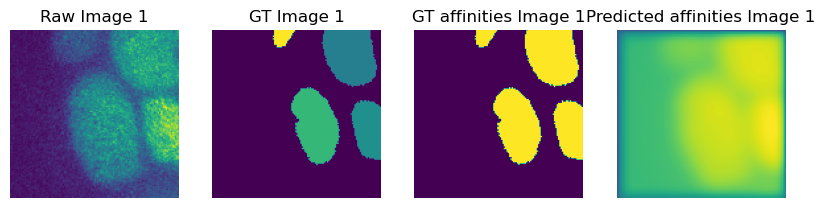

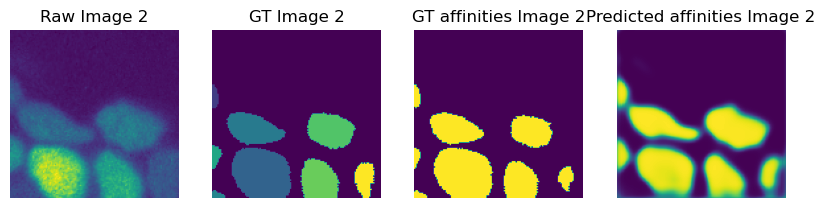

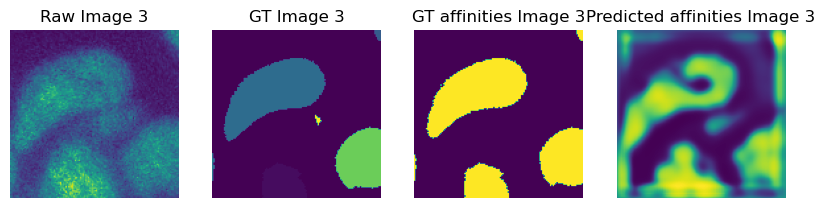

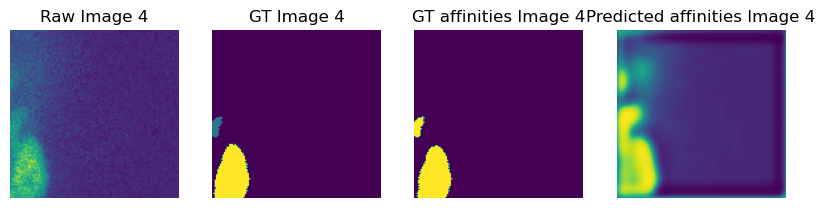

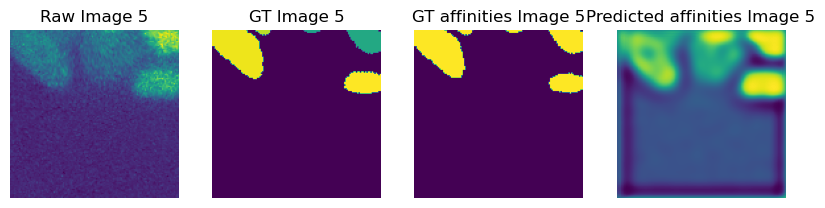

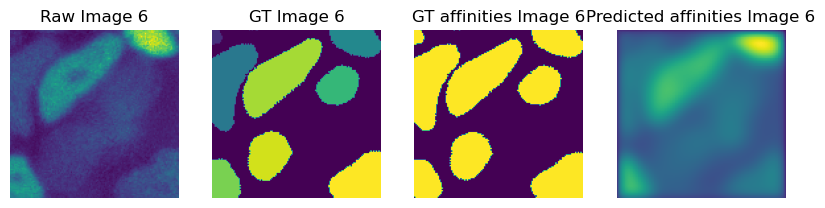

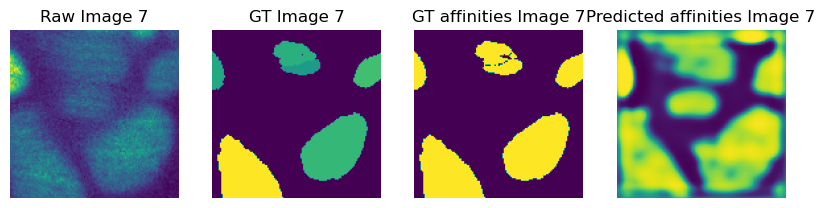

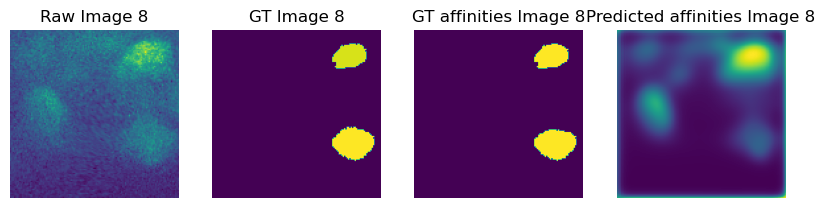

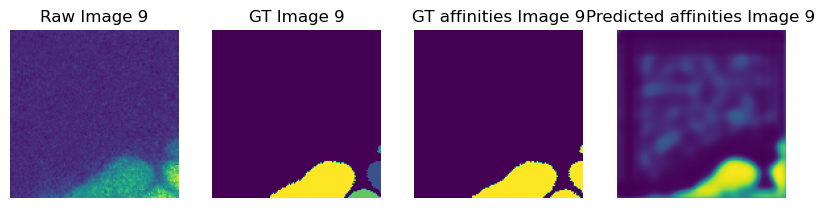

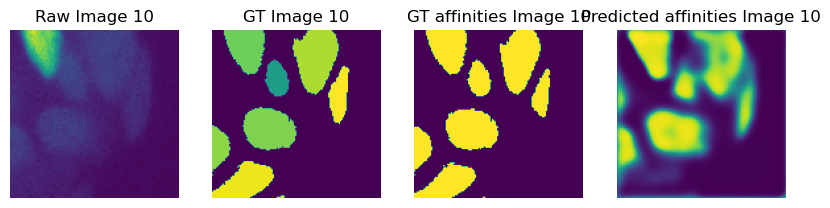

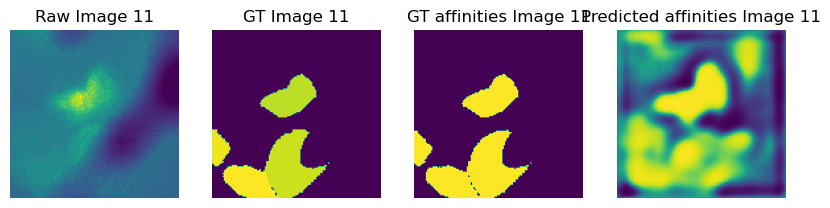

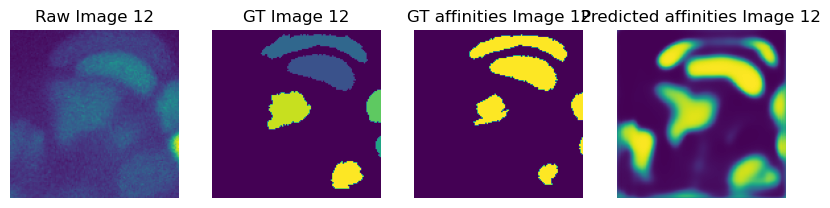

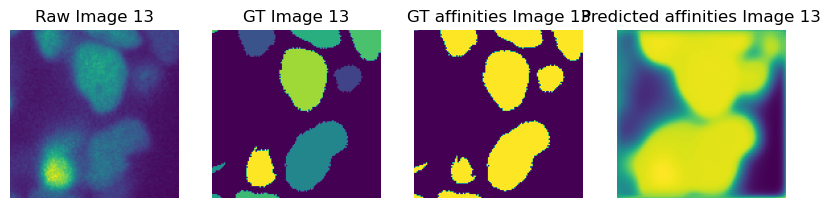

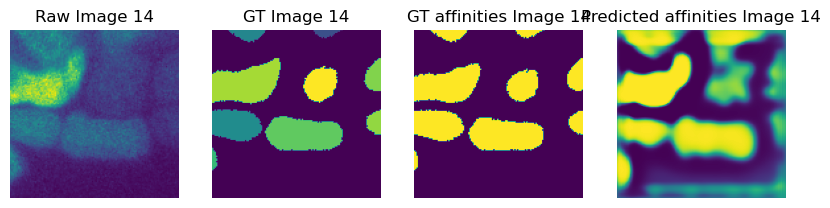

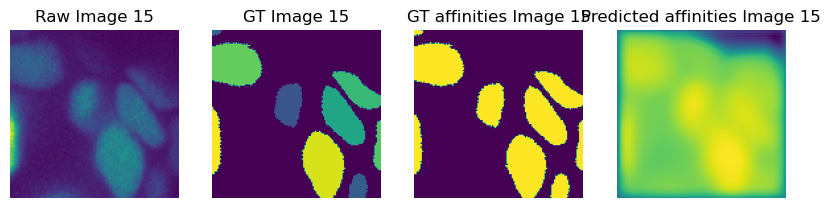

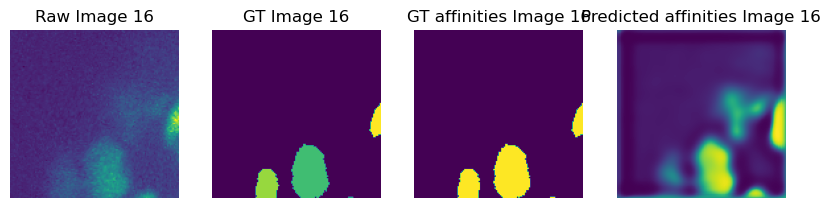

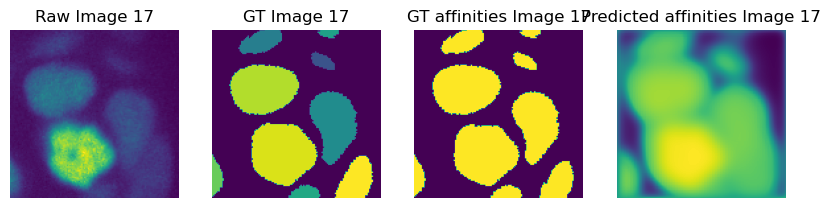

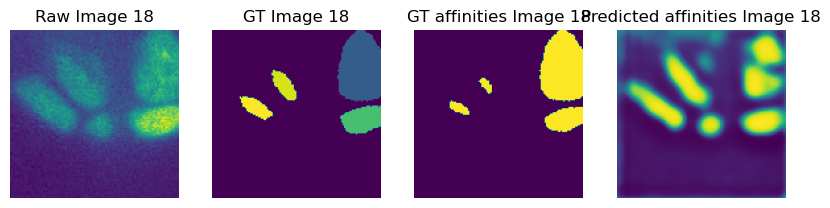

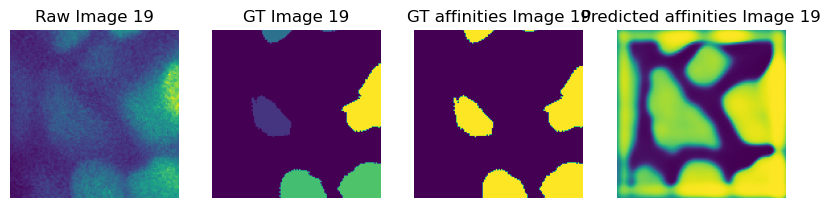

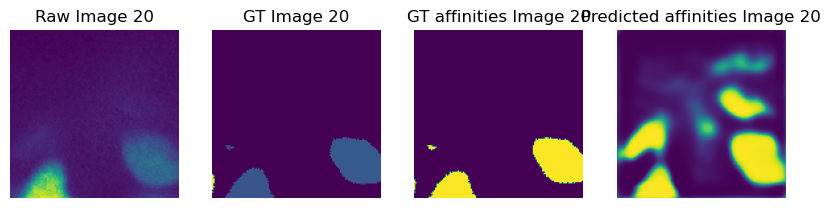

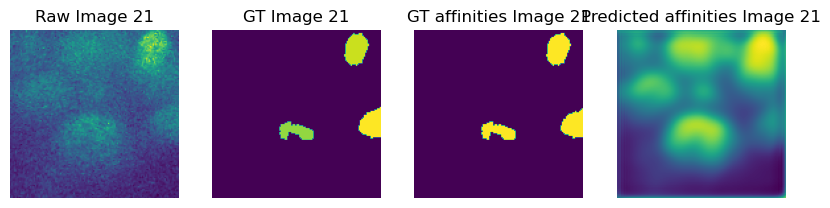

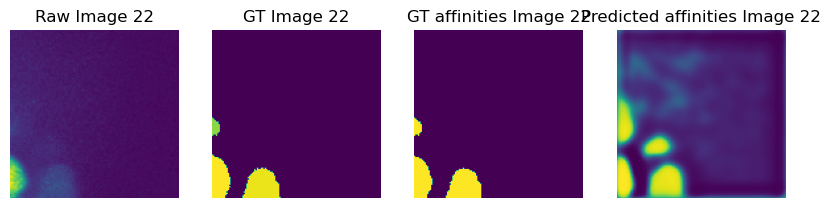

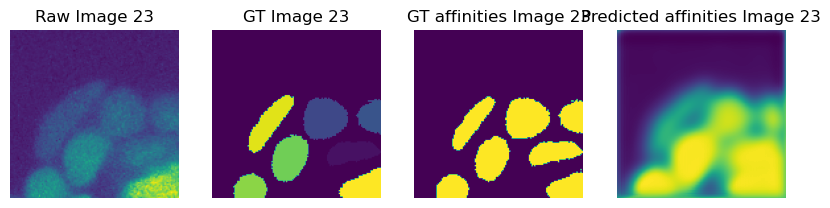

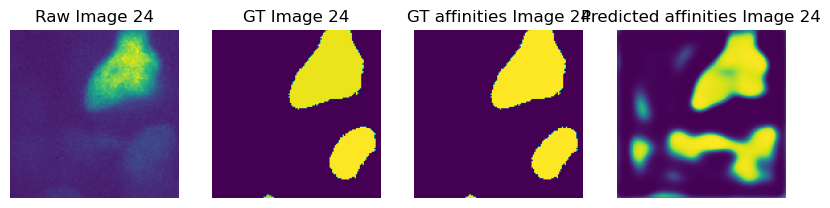

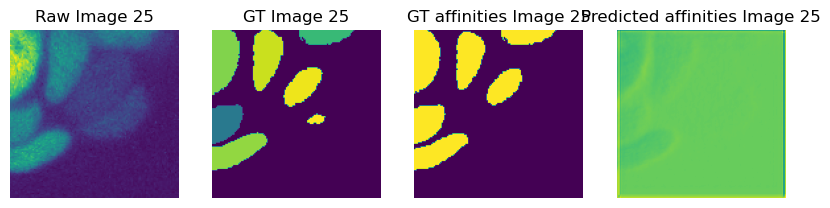

In [14]:
load_path = "/mnt/efs/shared_data/hack/lsd/mjs_onlyaffs_norm3000_exp5/snapshot"

# List all Zarr files in the folder
zarr_files = [file for file in os.listdir(load_path) if file.endswith('.zarr')]

# Create a dictionary to store 'raw' and 'gt' images
all_images = []

# Select the z-plane you want to view (replace with your desired z-plane)
z_plane_to_view = 12
affinity_to_view = 1

# Loop through each Zarr file
for zarr_file in zarr_files:
    # Open the Zarr file
    zarr_path = os.path.join(load_path, zarr_file)
    zarr_group = zarr.open(zarr_path, mode='r')
    # Check if the Zarr file contains 'raw' and 'gt' datasets
    if 'raw' in zarr_group and 'gt' in zarr_group and 'gt_affinities' in zarr_group and 'pred_affinities' in zarr_group:
        # Load a random example image from the 'raw' dataset
        random_index = random.randint(0, len(zarr_group['raw']) - 1)
        print(f'This is the random index: {random_index}')
        raw_image = zarr_group['raw'][random_index]
        raw_image = zarr_group['raw'][random_index][0, z_plane_to_view, :, :]

        # Load the corresponding 'gt' image
        gt_image = zarr_group['gt'][random_index][z_plane_to_view, :, :]

        #load the corresponding 'gt_affinities' image
        gt_affinities_image = zarr_group['gt_affinities'][random_index]
        print(f'This is the shape of gt_affinities before: {gt_affinities_image.shape}')
        gt_affinities_image = zarr_group['gt_affinities'][random_index][affinity_to_view, z_plane_to_view, :, :]
        print(f'This is the shape of gt_affinities after: {gt_affinities_image.shape}')

        # load the corresponding 'pred_affinities' image
        pred_affinities_image = zarr_group['pred_affinities'][random_index][affinity_to_view, z_plane_to_view, :, :]
        print(f'This is the shape of pred_affinities: {pred_affinities_image.shape}')
        # Append the 'raw' and 'gt' and 'gt_affinities' and 'pred_affinities' to the list
        all_images.append((raw_image, gt_image, gt_affinities_image, pred_affinities_image))



#%%

for i, (raw_image, gt_image, gt_affinities_image, pred_affinities_image) in enumerate(all_images):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 4, 1)
    plt.imshow(raw_image, cmap='viridis')
    plt.title(f'Raw Image {i+1}')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(gt_image, cmap='viridis')
    plt.title(f'GT Image {i+1}')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(gt_affinities_image, cmap='viridis')
    plt.title(f'GT affinities Image {i+1}')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(pred_affinities_image, cmap='viridis')
    plt.title(f'Predicted affinities Image {i+1}')
    plt.axis('off')

    plt.show()


TypeError: Invalid shape (20, 128, 128) for image data

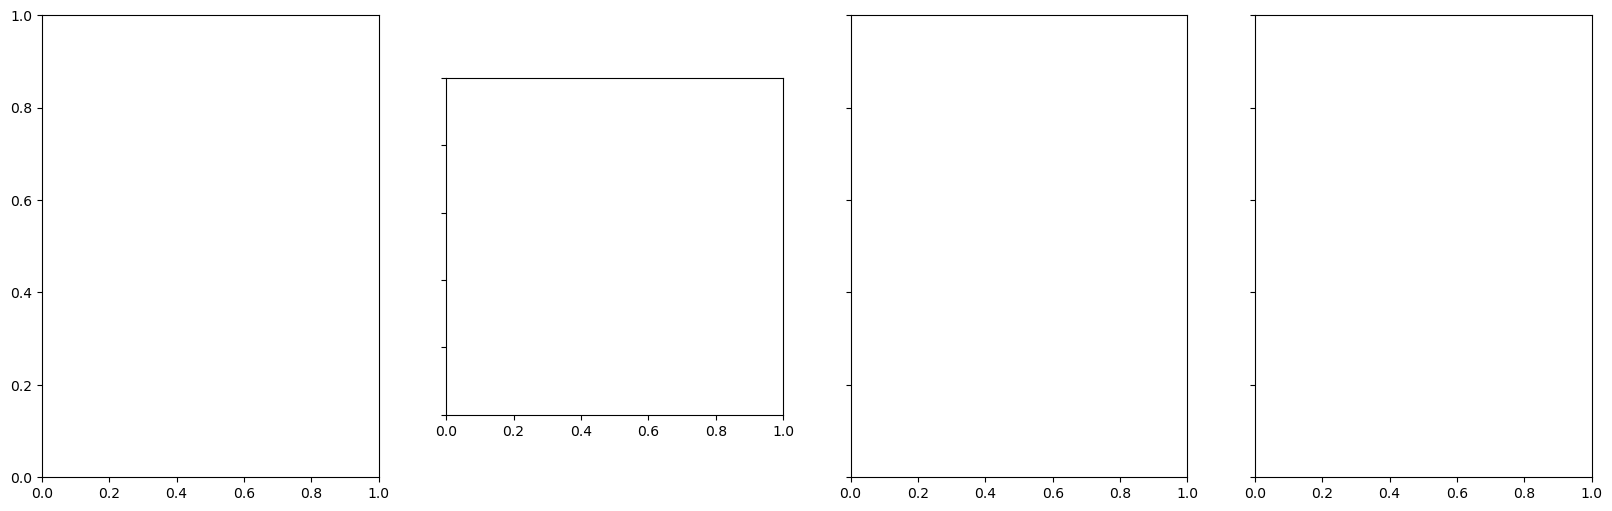

In [44]:
fig, axes = plt.subplots(
            1,
            4,
            figsize=(20, 6),
            sharex=True,
            sharey=True,
            squeeze=False)

# view predictions (for lsds we will just view the mean offset component)
# axes[0][0].imshow(raw, cmap='gray')
axes[0][1].imshow(np.squeeze(pred_affs[0]), cmap='jet')
# axes[0][2].imshow(np.squeeze(pred_lsds[0]), cmap='jet')
# axes[0][2].imshow(np.squeeze(pred_lsds[1]), cmap='jet', alpha=0.5)
axes[0][3].imshow(create_lut(np.squeeze(segmentation)))
     